На основании данных о пассажирах, которые воспользовались метро
дважды за сутки, при наличии информации о первом заходе в метро,
необходимо предсказать, на какой станции и через какой промежуток
времени, этот пассажир воспользуется метро повторно
На что стоит обратить внимание
Чтобы качественнее понимать задачу, стоит смоделировать
ежедневный маршрут москвича. Обычно это человек, который по будням
ездит из конечных станций в центр на работу/учебу, а после — возвращается
домой. В среднем рабочий день занимает 8 часов, а учебный 5-7.

# Import and description of dataset



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from plotly import express
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import recall_score, r2_score
from sklearn.model_selection import train_test_split
import math

from sklearn import preprocessing

pd.set_option('display.max_columns',100) 
pd.set_option('display.max_rows',100)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train_metro.csv')

# EDA & Feature engeeniring


Описание столбцов для train и test:
1. id - уникальный идентификатор столбца;
2. ticket_id - уникальный идентификатор билета, считается, что у одного
билета один владелец
3.  ticket_type_nm - тип билета
4.  entrance_id - уникальный id входа в станцию
5.  entrance_nm - название
6.  station_id - уникальное id станции захода
7.  station_nm - наименование станции захода
8.  line_id - уникальный id ветки на, которой находится станция
9.  line_nm - наименование ветки, на которой находится станция
10. pass_dttm - дата валидации
11. time_to_under (столбец для предсказания) - сколько времени прошло
между первой и второй валидацией
12. label (столбец для предсказания) - id второй станции, на которой
произошла валидация

In [ ]:
df.head(2)

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011


In [ ]:
def size(x, y):
  return plt.figure(figsize = (x, y))

In [ ]:
df.shape

(1091021, 12)

In [ ]:
df = df.drop(['id'], axis = 1)

In [ ]:
# проверка на дубликаты строк
df.loc[df.duplicated()]

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091021 entries, 0 to 1091020
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ticket_id       1091021 non-null  object 
 1   ticket_type_nm  1091021 non-null  object 
 2   entrance_id     1091021 non-null  int64  
 3   entrance_nm     1091021 non-null  object 
 4   station_id      1091021 non-null  int64  
 5   station_nm      1091021 non-null  object 
 6   line_id         1091021 non-null  int64  
 7   line_nm         1091021 non-null  object 
 8   pass_dttm       1091021 non-null  object 
 9   time_to_under   1091021 non-null  float64
 10  label           1091021 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 91.6+ MB


In [ ]:
def description(df):
    tmp = df.describe()
    tmp.loc['nan'] = [df[el].isna().sum() for el in df.describe().columns]
    tmp
    
    for el in df.columns:
        print(el)
        print(df[el].value_counts(dropna=False))
        print(f'NAN:{df[el].isna().sum()}')
        print(f' Unique:{df[el].nunique()}')
        print()

In [ ]:
description(df)

ticket_id
7992E92F9AE0F7506BD439547FD7E11F    8
15A93BB90FA63B7D1910B4C72EEA8AC6    8
0A223B8CF7138D96A287B99472BDC962    7
4CB7CC04C97C67A4D8CF280523B32B28    7
25DD6EFE304C3D3114ADE3F6025E84B4    7
                                   ..
1F6CDFF25D68AD5EB39A0E214FD7A6D0    1
75AD0BB4A6B4A64031100E33C128657F    1
9CB63B2330396EDB70F4819F2F212C9C    1
B5E3F454F5C3C6C3D46083AC49AFE3EE    1
3DF2B6366631ECA06274DD2CB5B0DF24    1
Name: ticket_id, Length: 335533, dtype: int64
NAN:0
 Unique:335533

ticket_type_nm
КОШЕЛЕК                                                   262499
30 дней ЕДИНЫЙ ТК                                         177041
Социальная карта москвича                                 127022
30 дней                                                   117064
90 дней ЕДИНЫЙ ТК                                          58071
30 дней СК студента                                        48658
60 поездок ЕДИНЫЙ ТК                                       46542
30 дней Пригород ТК               

Удалим столбцы с названиями входа, станции и линии (тк у нас есть по ним коды)

In [ ]:
df= df.drop(columns=['entrance_nm','station_nm', 'line_nm'])

Посмотрим распределение по целевым признакам

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1500.0)

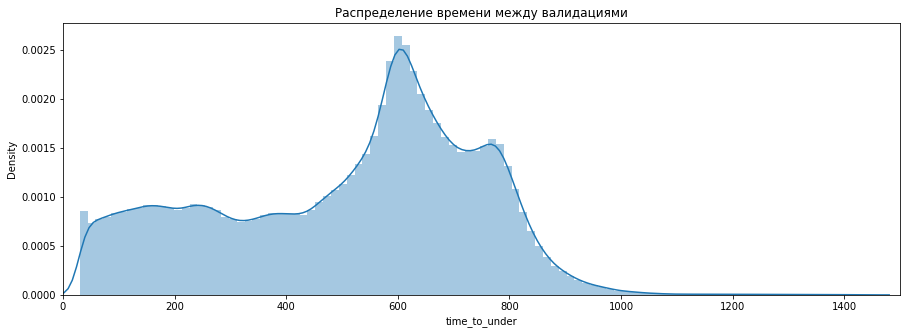

In [ ]:
size(15, 5)
sns.distplot(df.time_to_under, bins=100)
plt.title('Распределение времени между валидациями')
plt.xlim(0, 1500)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Распределение станции при второй валидации')

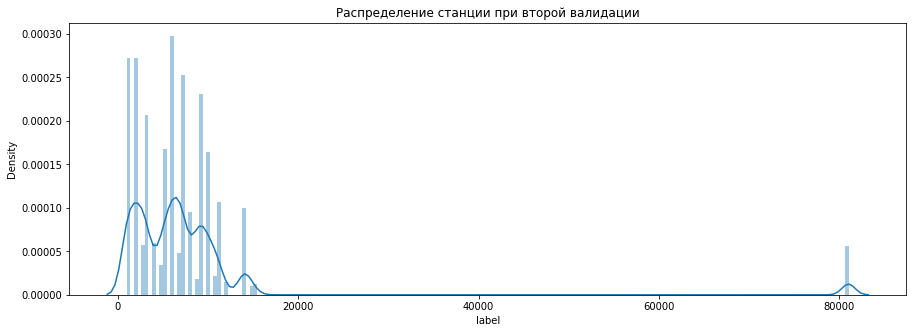

In [ ]:
size(15, 5)
sns.distplot(df.label, bins=200)
plt.title('Распределение станции при второй валидации')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Распределение станции при первой валидации')

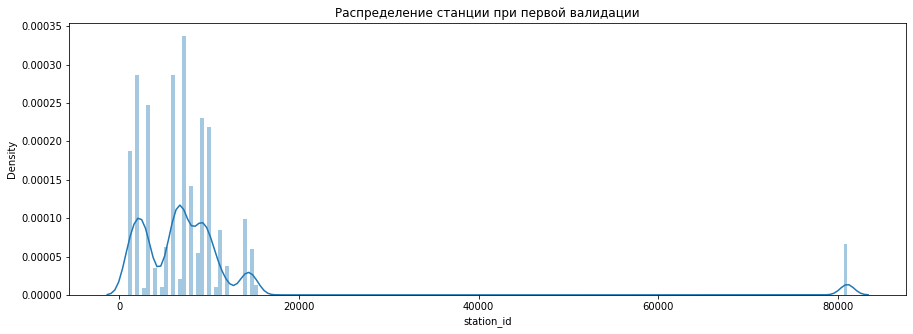

In [ ]:
size(15, 5)
sns.distplot(df.station_id, bins=200)
plt.title('Распределение станции при первой валидации')

In [ ]:
df.line_id.value_counts()

7     156031
6     125065
2     124918
9     124079
3     112407
10     95624
1      81818
8      61961
14     43385
11     41317
5      31884
15     31858
81     28768
12     16696
4      15077
13       133
Name: line_id, dtype: int64

In [ ]:
df.station_id.value_counts()[12:]

7018     12652
10018    12350
2023     12246
7007     12156
3018     11963
         ...  
13005       20
13001       16
13006       10
13004        9
13002        8
Name: station_id, Length: 264, dtype: int64

In [ ]:
df = df.drop(df[df.line_id == 13].index)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


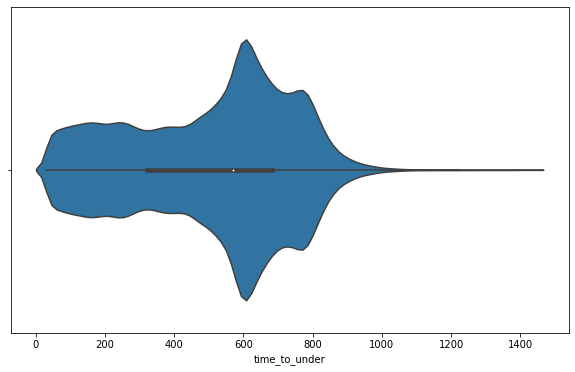

In [ ]:
size(10,6)
sns.violinplot(df.time_to_under)

In [ ]:
df.query('time_to_under > 1000')

,ticket_id,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label
3,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,2006,2,2022-09-12 05:01:13,1048.233333,2022
12,73F283E81B8E0524E3DED3CAF050E62A,90 дней ЕДИНЫЙ ТК,107,2018,2,2022-09-12 05:06:36,1051.883333,3015
63,EB6D484427DC14BFEF8727B346F7A96C,30 дней Пригород ТК,218,8003,8,2022-09-12 05:22:53,1029.400000,4004
102,DB2371D5803440428BCB20478A64F68F,30 дней,297,7004,7,2022-09-12 05:24:27,1044.500000,7002
104,82325F8073E15113B4C8C4F52B0C20AF,30 дней ЕДИНЫЙ ТК,394,9023,9,2022-09-12 05:24:32,1016.900000,2013
...,...,...,...,...,...,...,...,...
982434,5C6F6186684ECF925F724C78E85CA159,СК учащегося 30 дней,106,2018,2,2022-09-18 06:55:51,1021.450000,3005
982650,B3F885511050F5A3DA2318F6EB78A8E9,30 дней СК учащегося,354,9012,9,2022-09-18 06:56:58,1009.816667,2013
982873,2E0BC74863D4DFD4989C068040BF40E2,30 дней Пригород ТК,304,7009,7,2022-09-18 06:58:09,1011.750000,7003
983384,0564AE5D2B48F1430305BA4ED5027D14,КОШЕЛЕК,2100,2002,2,2022-09-18 07:00:39,1004.483333,2008


In [ ]:
df = df.drop(df[df.time_to_under > 1000].index)

Переведем тип билета в категориальный вид

In [ ]:
encoder = preprocessing.LabelEncoder()
encoder = encoder.fit(df.ticket_type_nm)
df.ticket_type_nm = encoder.transform(df.ticket_type_nm)

У нас очень много уникальных значений в стороке с номером билета (30% от всех данных), удалим их

In [ ]:
df = df.drop(["ticket_id"], axis = 1)

У нас есть столбец с датой и временем первой валидации. Поскольку задача не по временныи рядам, попробуем взять из этих данных часть. Месяц и год у нас один и тот же, можно взять дату (как вариант еще с меткой выходной ли день) и час и минуты.

In [ ]:
df["day"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))
df["hour"] = df.pass_dttm.map(lambda x: (int(x.split("-")[2].split(" ")[1].split(":")[0]) * 60))
df["minute"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[1]))


In [ ]:
df['time'] = df['hour'] + df['minute']

In [ ]:
df.tail()

,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label,day,hour,minute,time
1091016,40,2283,15005,15,2022-09-19 02:54:50,124.750000,15005,19,120,54,174
1091017,40,278,6007,6,2022-09-19 03:06:02,56.066667,6007,19,180,6,186
1091018,40,118,2010,2,2022-09-19 03:17:00,91.283333,2010,19,180,17,197
1091019,40,2452,11014,11,2022-09-19 03:23:30,47.900000,11014,19,180,23,203
1091020,40,320,7015,7,2022-09-19 04:10:42,34.100000,7015,19,240,10,250


In [ ]:
df['weekend'] = df['day']
df['weekend'] = df['weekend'].replace(17, 1)
df['weekend'] = df['weekend'].replace(18, 1)
df.loc[(df.weekend > 1), 'weekend'] = 0
df['weekend'].value_counts()

0    831400
1    255513
Name: weekend, dtype: int64

In [ ]:
df = df.drop(['pass_dttm', 'hour', 'minute', 'line_id'], axis = 1)

Теперь осмотрим зависимость целевых признаков на графике

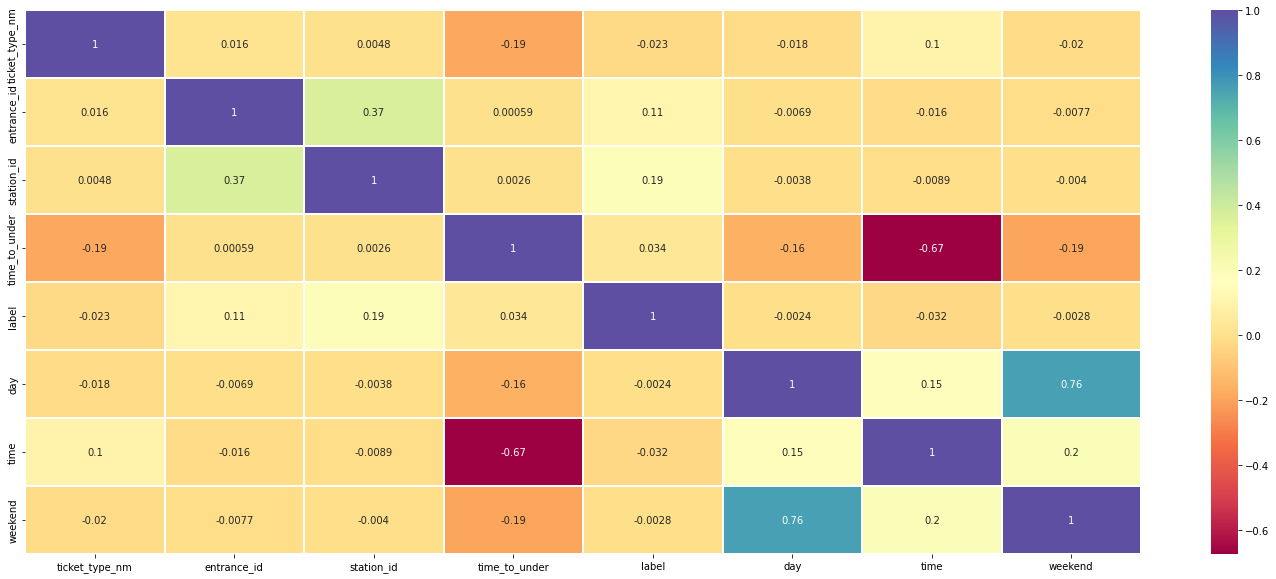

In [ ]:
plt.figure(figsize = (25, 10))
sns.heatmap(df.corr(), annot = True, linewidths=0.8, cmap = 'Spectral')

Перевод числовых данных в формат int8 с проверкой с целью уменьшения размера данных

In [ ]:
num_feat = df.select_dtypes('int64')
for el in num_feat:
    for n_type in (np.int32, np.int16, np.int8):
        if (df[el] == df[el].astype(n_type)).sum() == len(df):
            df[el] = df[el].astype(n_type)

In [ ]:
y = df[['time_to_under', 'label']]

In [ ]:
X = df.drop(columns = ['time_to_under', 'label'])

In [ ]:
y.value_counts()

time_to_under  label
37.500000      3023     7
37.583333      3023     7
36.083333      3023     7
605.883333     6007     6
681.166667     6019     6
                       ..
426.916667     11008    1
426.933333     1022     1
               2007     1
               3002     1
1000.000000    6020     1
Length: 1009455, dtype: int64

In [ ]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()
#X_sm, y_sm = smote.fit_resample(X, y)


**Split dataset**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




#Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [ ]:
rfc_model = RandomForestClassifier(n_estimators = 50, random_state = 42, max_depth=12)

In [ ]:
rfc_model.fit(X_train, y_train['label'])
y_rfc_clas = rfc_model.predict(X_test)
recall = recall_score(y_test['label'], y_rfc_clas, average = "macro" )
print(f'Recall test {round(recall, 4)}')

Recall test 0.0674


In [ ]:
rfr_model = RandomForestRegressor(n_estimators = 70, random_state = 42, max_depth=12, min_samples_leaf=5)

In [ ]:
rfr_model.fit(X_train, y_train['time_to_under'])
y_rfc_reg = rfr_model.predict(X_test)
r2 = r2_score(y_test["time_to_under"], y_rfc_reg)
print(f'R2 test {round(r2, 4)}')

R2 test 0.5332


['4']


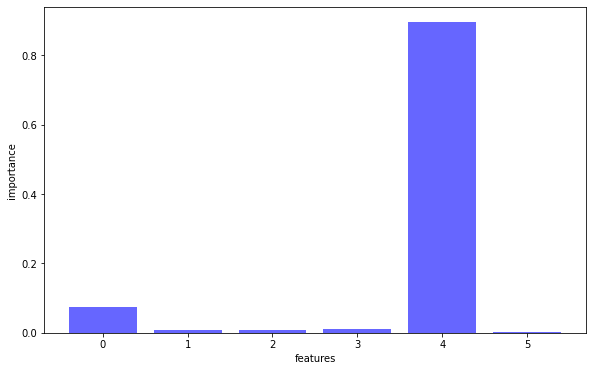

In [ ]:
# Выбор важных признаков

important_features = []
for x,i in enumerate(rfr_model.feature_importances_):
    if i>np.average(rfr_model.feature_importances_):
        important_features.append(str(x))
print (important_features)


plt.figure(figsize=(6 * 1.618, 6))
feature_import=rfr_model.feature_importances_
index = np.arange(len(feature_import))
plt.bar(index, feature_import, color='blue', alpha=0.6)
plt.xlabel('features')
plt.ylabel('importance')
plt.xticks(index)
plt.show()

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869530 entries, 641470 to 122132
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   ticket_type_nm  869530 non-null  int64
 1   entrance_id     869530 non-null  int64
 2   station_id      869530 non-null  int64
 3   day             869530 non-null  int64
 4   time            869530 non-null  int64
 5   weekend         869530 non-null  int64
dtypes: int64(6)
memory usage: 46.4 MB


#Light GBM

In [ ]:
!pip install lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
lgbm = LGBMClassifier(n_estimators = 20, random_state=42)

In [ ]:
lgbm.fit(X_train, y_train['label'])
y_lgb_clas = lgbm.predict(X_test)
recall = recall_score(y_test['label'], y_lgb_clas, average = "macro" )
print(f'Recall test {round(recall, 4)}')

Recall test 0.0677


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
lgb = LGBMRegressor(n_estimators = 400, random_state=42, num_leaves=40)

In [ ]:
lgb.fit(X_train, y_train['time_to_under'])
y_lgb_reg = lgb.predict(X_test)
r2 = r2_score(y_test["time_to_under"], y_lgb_reg)
print(f'R2 test {round(r2, 4)}')

R2 test 0.5375


In [ ]:
result = 0.5 * r2 + 0.5 * recall
print('Result', result)

Result 0.30261983628865774


# TEST

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/test_metro.csv')

In [ ]:
test = test.drop(columns = ['entrance_nm','station_nm', 'line_nm', 'id', 'ticket_id'])

test["day"] = test.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))
test["hour"] = test.pass_dttm.map(lambda x: (int(x.split("-")[2].split(" ")[1].split(":")[0]) * 60))
test["minute"] = test.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))
test["minute"] = test.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[1]))

encoder = preprocessing.LabelEncoder()
encoder = encoder.fit(test.ticket_type_nm)
test.ticket_type_nm = encoder.transform(test.ticket_type_nm)

test['time'] = test['hour'] + test['minute']

#test = test.drop(test[test.line_id == 13].index)

test['weekend'] = test['day']
test['weekend'] = test['weekend'].replace(17, 1)
test['weekend'] = test['weekend'].replace(18, 1)

test.loc[(test.weekend > 1), 'weekend'] = 0
test['weekend'].value_counts()

test = test.drop(['pass_dttm', 'hour', 'minute', 'line_id'], axis = 1)


num_feat = test.select_dtypes('int64')
for el in num_feat:
    for n_type in (np.int32, np.int16, np.int8):
        if (test[el] == test[el].astype(n_type)).sum() == len(test):
            test[el] = test[el].astype(n_type)

In [ ]:
label = lgbm.predict(test)

In [ ]:
time_to_under = lgb.predict(test)

In [ ]:
label.shape

(561890,)

In [ ]:
answer = []
my_answer = pd.DataFrame(data=answer)
my_answer['time_to_under'] = pd.DataFrame(data=time_to_under)
my_answer['label'] = pd.DataFrame(data=label)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/test_metro.csv')

In [ ]:
test = test.drop(columns = ['entrance_nm','station_nm', 'line_nm', 'ticket_id'])

In [ ]:
my_answer = test.join(my_answer)

In [ ]:
my_answer = my_answer[['id', 'time_to_under', 'label']]

In [ ]:
my_answer

,id,time_to_under,label
0,1091022,521.999788,2022
1,1091023,530.648072,81016
2,1091024,586.436845,2022
3,1091025,509.410154,3017
4,1091026,521.999788,2022
...,...,...,...
561885,1652907,23.676074,1002
561886,1652908,164.396540,14016
561887,1652909,19.230991,14010
561888,1652910,28.429281,11017


In [ ]:
my_answer.to_csv('solution_3.csv',index=False)